In [31]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_absolute_error, make_scorer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import pickle
import hyperopt.pyll.stochastic
import time

In [32]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['loss'] = np.nan
joined = pd.concat([train, test])

In [33]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print "Categorical features:", len(cat_features)
print "Numerical features:", len(num_features)

Categorical features: 116
Numerical features: 14


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [35]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels)),False

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat)),False

def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [36]:
df = pd.DataFrame({'A':[np.nan,'type1','type2'],
                   'B':['type1','type2','type3'],
                   'C':['type1','type3','type3']})
print pd.factorize(df['A'].values, sort=True)[0]
print pd.factorize(df['A'].values)[0]
print pd.factorize(df['B'].values, sort=True)[0]
print pd.factorize(df['C'].values, sort=True)[0]
print pd.factorize(df['A'].values)[0]+1

[-1  0  1]
[-1  0  1]
[0 1 2]
[0 1 1]
[0 1 2]


In [37]:
for column in list(train.select_dtypes(include=['object']).columns):
    if train[column].nunique() != test[column].nunique():
        set_train = set(train[column].unique())
        set_test = set(test[column].unique())
        remove_train = set_train - set_test
        remove_test = set_test - set_train

        remove = (remove_train|remove_test)
        def filter_cat(x):
            if x in remove:
                return np.nan
            return x

        joined[column] = joined[column].apply(lambda x: 'np.nan' if x in remove else x, 1)

    joined[column] = pd.factorize(joined[column].values, sort=True,na_sentinel=-1)[0]
    joined[column] = joined[column] + 1

train = joined[joined['loss'].notnull()]
test = joined[joined['loss'].isnull()]

shift = 200
y = np.log(train['loss'] + shift)
ids = test['id']
X = train.drop(['loss', 'id'], 1)
X_test = test.drop(['loss', 'id'], 1)
lgtrain = lgb.Dataset(X, label=y)
lgtest = lgb.Dataset(X_test)

In [391]:
%%time
lgb_params={'sub_row': 0.9, 'num_leaves': 134, 'reg_alpha': 1e-05, 'num_threads': 10,   
             'sub_feature': 0.5, 'min_child_weight': 52, 'min_split_gain': 0.1,      
             'reg_lambda': 1, 'num_boost_round': 3000, 'max_depth': 19,        
             'learning_rate':0.01}
model = lgb.train(params, lgtrain, 3000, feval=evalerror)

CPU times: user 11min 33s, sys: 2.66 s, total: 11min 36s
Wall time: 1min 10s


In [392]:
prediction = np.exp(model.predict(X_test)) - shift
submission = pd.DataFrame()
submission['loss'] = prediction
submission['id'] = ids
submission.to_csv('sub_v.csv', index=False)

In [43]:
#1139
lgb_params= {'sub_row': 0.9, 'num_leaves': 134, 'reg_alpha': 1e-05, 'num_threads': 10,   
             'sub_feature': 0.5, 'min_child_weight': 52, 'min_split_gain': 0.1,      
             'reg_lambda': 1,  'max_depth': 19,        
             'learning_rate':0.01}
'''lgb_params= {'sub_row': 0.87, 'num_leaves': 125, 'sub_feature': 0.74, 'verbose': 1, 
             'reg_alpha': 0.8638205946822382, 'min_child_weight': 24, 'nthread': 10,
             'reg_lambda': 564.8140150688292, 'min_split_gain': 0.55, 'bagging_freq': 1,
             'max_depth': 14,'learning_rate':0.01}'''

"lgb_params= {'sub_row': 0.87, 'num_leaves': 125, 'sub_feature': 0.74, 'verbose': 1, \n             'reg_alpha': 0.8638205946822382, 'min_child_weight': 24, 'nthread': 10,\n             'reg_lambda': 564.8140150688292, 'min_split_gain': 0.55, 'bagging_freq': 1,\n             'max_depth': 14,'learning_rate':0.01}"

In [44]:
%%time
cv_result_lgb = lgb.cv(lgb_params, lgtrain, num_boost_round=3000, nfold=10, stratified=False,
                    feval=evalerror, early_stopping_rounds=None)
print cv_result_lgb['mae-mean'][-1]
print('\nBest num_boost_round:', len(cv_result_lgb['mae-mean']))

1135.23032664
('\nBest num_boost_round:', 3000)
CPU times: user 2h 4min 33s, sys: 30.5 s, total: 2h 5min 3s
Wall time: 12min 30s


In [45]:
np.argmin(cv_result_lgb['mae-mean'])

2268

In [46]:
np.min(cv_result_lgb['mae-mean'])

1135.2302430778702

In [47]:
cv_result_lgb['mae-mean'][np.argmin(cv_result_lgb['mae-mean'])]

1135.2302430778702

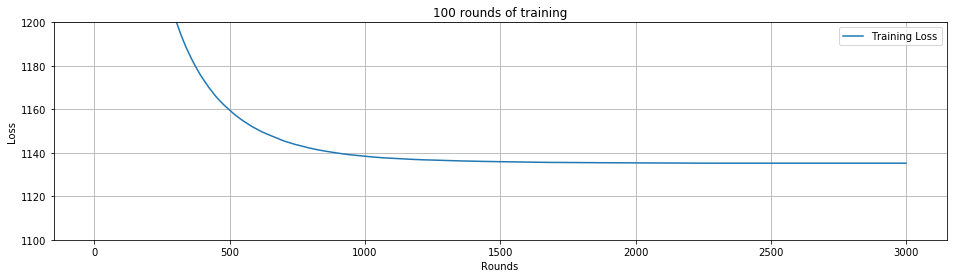

In [48]:
fig, ax1 = plt.subplots(1,1)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.set_ylim(1100,1200)
ax1.grid(True)
ax1.plot(cv_result_lgb['mae-mean'])
ax1.legend(['Training Loss', 'Test Loss'])

fig.set_size_inches(16,4)
#fig.subplots_adjust(hspace=0)
plt.show()

In [107]:
from sklearn.model_selection import StratifiedKFold
Xt = np.zeros((1000,100))
t = np.ones((1000,100))
yt=np.concatenate((np.zeros(500),np.ones(500)))
skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(Xt, yt):
    t[test_index] = 0
np.where(t)

(array([], dtype=int64), array([], dtype=int64))

In [9]:
def plottrend(grid,bins):    
    test_scores_mean = grid.cv_results_['mean_test_score']
    test_scores_std = grid.cv_results_['std_test_score']
    plt.grid()
    plt.fill_between(bins, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,color="r")
    plt.plot(bins, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.show()

-1145.90798448
{'sub_row': 0.9, 'num_leaves': 134, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 52, 'min_split_gain': 0.1, 'reg_lambda': 1, 'num_boost_round': 100, 'max_depth': 19}


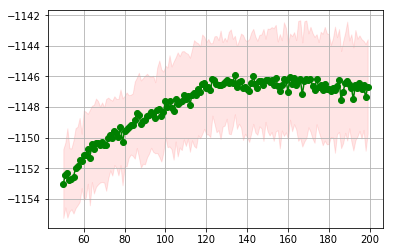

CPU times: user 3h 59min 59s, sys: 3min 25s, total: 4h 3min 24s
Wall time: 29min 16s


In [81]:
%%time
bins = range(50,200,1)
lgb_params = {
    'num_leaves':bins,
    'min_child_weight': [52],
     'max_depth':[19],
    'min_split_gain':[0.1],
    'sub_feature': [0.5],
    'sub_row': [0.9],
    'reg_alpha':[0.00001],
    'reg_lambda':[1],
    'num_boost_round':[50],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=bins)

-1145.56474293
{'sub_row': 0.9, 'num_leaves': 134, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 85, 'min_split_gain': 0.1, 'reg_lambda': 1, 'num_boost_round': 100, 'max_depth': 19}


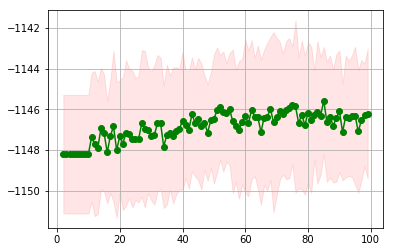

CPU times: user 2h 44min 49s, sys: 2min 21s, total: 2h 47min 11s
Wall time: 20min 3s


In [185]:
%%time
bins = range(2,100,1)
lgb_params = {
    'num_leaves':[134],
    'min_child_weight': bins,
    'max_depth':[19],
    'min_split_gain':[0.1],
    'sub_feature': [0.5],
    'sub_row': [0.9],
    'reg_alpha':[0.00001],
    'reg_lambda':[1],
    'num_boost_round':[100],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=bins)

-1145.56474293
{'sub_row': 0.9, 'num_leaves': 134, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 85, 'min_split_gain': 0.1, 'reg_lambda': 1, 'num_boost_round': 100, 'max_depth': 19}


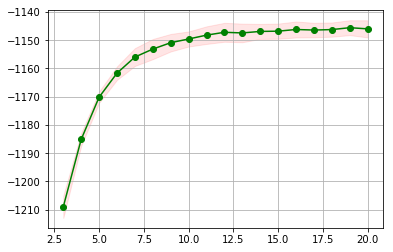

CPU times: user 27min 15s, sys: 25.1 s, total: 27min 40s
Wall time: 3min 22s


In [188]:
%%time
bins = range(3,21,1)
lgb_params = {
    'num_leaves':[134],
    'min_child_weight': [85],
     'max_depth':bins,
    'min_split_gain':[0.1],
    'sub_feature': [0.5],
    'sub_row': [0.9],
    'reg_alpha':[0.00001],
    'reg_lambda':[1],
    'num_boost_round':[100],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=bins)

-1145.53150343
{'sub_row': 0.9, 'num_leaves': 134, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 85, 'min_split_gain': 0.06, 'reg_lambda': 1, 'num_boost_round': 100, 'max_depth': 19}


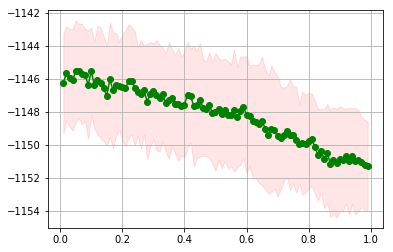

CPU times: user 2h 38min 6s, sys: 1min 57s, total: 2h 40min 3s
Wall time: 19min 26s


In [190]:
%%time
bins = [ 0.01 * i for i in range(1,100,1)]
lgb_params = {
    'num_leaves':[134],
    'min_child_weight': [85],
     'max_depth':[19],
    'min_split_gain':bins, 
    'sub_feature': [0.5],
    'sub_row': [0.9],
    'reg_alpha':[0.00001],
    'reg_lambda':[1],
    'num_boost_round':[100],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=bins)

-1148.49842038
{'sub_row': 0.9, 'num_leaves': 134, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 85, 'min_split_gain': 0.1, 'reg_lambda': 1, 'num_boost_round': 100, 'bagging_freq': 0, 'max_depth': 19}


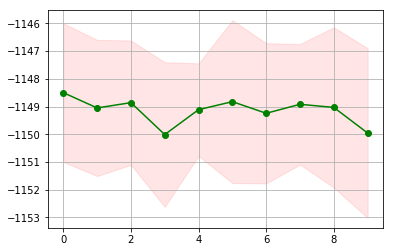

CPU times: user 19min 4s, sys: 12.3 s, total: 19min 16s
Wall time: 2min 16s


In [192]:
%%time
bins = range(10)
lgb_params = {
    'num_leaves':[134],
    'min_child_weight': [85],
     'max_depth':[19],
    'min_split_gain':[0.1],
    'bagging_freq': bins,
    'sub_feature': [0.5],
    'sub_row': [0.9],
    'reg_alpha':[0.00001],
    'reg_lambda':[1],
    'num_boost_round':[100],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=bins)

-1145.40760589
{'sub_row': 0.9, 'num_leaves': 146, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 52, 'min_split_gain': 0.1, 'n_estimators': 100, 'reg_lambda': 1e-05, 'num_boost_round': 100, 'max_depth': 19}


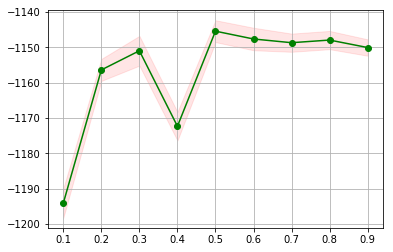

CPU times: user 16min 7s, sys: 14 s, total: 16min 21s
Wall time: 1min 57s


In [17]:
%%time
bins = [i/10.0 for i in range(1,10)]
lgb_params = {
    'num_leaves':[134],
    'min_child_weight': [85],
     'max_depth':[19],
    'min_split_gain':[0.1], 
    'sub_feature': bins,
    'sub_row': [0.9],
    'reg_alpha':[0.00001],
    'reg_lambda':[1],
    'num_boost_round':[100],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=bins)

-1145.40760589
{'sub_row': 0.9, 'num_leaves': 146, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 52, 'min_split_gain': 0.1, 'n_estimators': 100, 'reg_lambda': 1e-05, 'num_boost_round': 100, 'max_depth': 19}


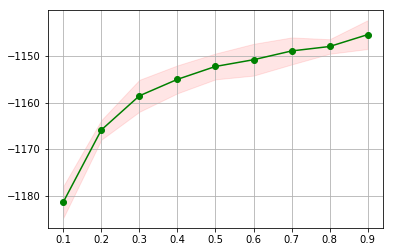

CPU times: user 13min 46s, sys: 14.1 s, total: 14min
Wall time: 1min 42s


In [18]:
%%time
bins = [i/10.0 for i in range(1,10)]
lgb_params = {
    'num_leaves':[134],
    'min_child_weight': [85],
     'max_depth':[19],
    'min_split_gain':[0.1], 
    'sub_feature': [0.5],
    'sub_row': bins,
    'reg_alpha':[0.00001],
    'reg_lambda':[1],
    'num_boost_round':[100],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=bins)

-1145.40760589
{'sub_row': 0.9, 'num_leaves': 146, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 52, 'min_split_gain': 0.1, 'n_estimators': 100, 'reg_lambda': 1e-05, 'num_boost_round': 100, 'max_depth': 19}


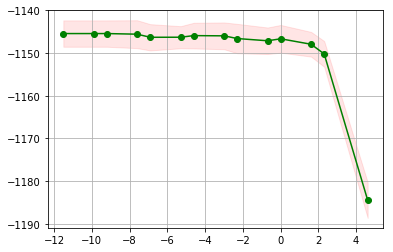

CPU times: user 24min, sys: 23.8 s, total: 24min 24s
Wall time: 2min 55s


In [34]:
%%time
bins = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2, 5e-2,0.1,0.5, 1,5,10,100]
lgb_params = {
    'num_leaves':[134],
    'min_child_weight': [85],
     'max_depth':[19],
    'min_split_gain':[0.1], 
    'sub_feature': [0.5],
    'sub_row': [0.9],
    'reg_alpha':bins,
    'reg_lambda':[1],
    'num_boost_round':[100],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=np.log(bins))

-1145.40760589
{'sub_row': 0.9, 'num_leaves': 146, 'reg_alpha': 1e-05, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 52, 'min_split_gain': 0.1, 'n_estimators': 100, 'reg_lambda': 1e-05, 'num_boost_round': 100, 'max_depth': 19}


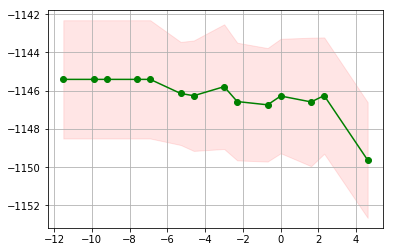

CPU times: user 23min 59s, sys: 23.7 s, total: 24min 23s
Wall time: 2min 58s


In [35]:
%%time
bins = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2, 5e-2,0.1,0.5, 1,5,10,100]
lgb_params = {
    'num_leaves':[134],
    'min_child_weight': [85],
     'max_depth':[19],
    'min_split_gain':[0.1], 
    'sub_feature': [0.5],
    'sub_row': [0.9],
    'reg_alpha':[1e-05],
    'reg_lambda':bins,
    'num_boost_round':[100],
    'num_threads':[10],
}
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=np.log(bins))

In [ ]:
%%time
binn = {}
binn['num_leaves'] = range(100,300,20)
binn['min_child_weight'] = range(2,100,40)
binn['max_depth'] = [25]
binn['min_split_gain'] = [ 0.1 * i for i in range(0,3,1)]
binn['sub_feature'] = [i*0.1 for i in range(5,10)]
binn['sub_row'] = [i*0.1 for i in range(5,10)]
binn['bagging_freq'] = range(0,2,1)
binn['num_boost_round']=[100]
binn['reg_alpha'] = [1e-4,1e-3,1e-2, 0.1]
binn['reg_lambda'] = [1e-4,1e-3,1e-2, 0.1]
clf=lgb.LGBMRegressor()
grid = GridSearchCV(clf,param_grid=binn, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_
plottrend(grid=grid,bins=np.log(bins))

/home/phe002/anaconda2/lib/python2.7/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
print grid.best_score_
print grid.best_params_

In [396]:
binn = {}
binn['num_leaves'] = range(100,200,2)
binn['min_child_weight'] = range(2,100,2)
binn['max_depth'] = range(3,21,1)
binn['min_split_gain'] = [ 0.1 * i for i in range(0,10)]
binn['sub_feature'] = [i*0.1 for i in range(5,10)]
binn['sub_row'] = [i*0.1 for i in range(5,10)]
binn['bagging_freq'] = range(0,10,1)
binn['reg_alpha'] = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2, 5e-2,0.1,0,1,5]
binn['reg_lambda'] = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2, 5e-2,0.1,0,1,5]
tuningparams = ['num_leaves','min_child_weight','max_depth','min_split_gain',
                'sub_feature','sub_row','bagging_freq','reg_alpha','reg_lambda']

In [ ]:
%%time
import json
lgb_params = {"num_leaves": [156], "sub_feature": [0.5], "reg_alpha": [0.5], 
"num_boost_round": [100], "bagging_freq": [0], "sub_row": [0.1], 
"num_threads": [10], "min_child_weight": [90], "min_split_gain": [0.03], 
"reg_lambda": [0.005], "max_depth": [16]}
while True:
    for para in tuningparams:
        lgb_params[para] = binn[para]
        clf=lgb.LGBMRegressor()
        grid = GridSearchCV(clf,param_grid=lgb_params, cv=3, scoring=mae_scorer)
        grid.fit(X, y)
        print grid.best_score_
        print grid.best_params_
        lgb_params[para] = [grid.best_params_[para]]
    with open('lgb_params.json', 'w') as file:
         file.write(json.dumps(lgb_params))
lgb_params

-1147.65466407
{'sub_row': 0.1, 'num_leaves': 104, 'reg_alpha': 0.5, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 90, 'min_split_gain': 0.03, 'reg_lambda': 0.005, 'num_boost_round': 100, 'bagging_freq': 0, 'max_depth': 16}
-1147.65466407
{'sub_row': 0.1, 'num_leaves': 104, 'reg_alpha': 0.5, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 90, 'min_split_gain': 0.03, 'reg_lambda': 0.005, 'num_boost_round': 100, 'bagging_freq': 0, 'max_depth': 16}
-1147.65466407
{'sub_row': 0.1, 'num_leaves': 104, 'reg_alpha': 0.5, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 90, 'min_split_gain': 0.03, 'reg_lambda': 0.005, 'num_boost_round': 100, 'bagging_freq': 0, 'max_depth': 16}
-1148.55442167
{'sub_row': 0.1, 'num_leaves': 104, 'reg_alpha': 0.5, 'num_threads': 10, 'sub_feature': 0.5, 'min_child_weight': 90, 'min_split_gain': 0.0, 'reg_lambda': 0.005, 'num_boost_round': 100, 'bagging_freq': 0, 'max_depth': 16}
-1148.55442167
{'sub_row': 0.1, 'num_leaves': 104, 'r

-1146.95525945
{'sub_row': 0.5, 'num_leaves': 120, 'reg_alpha': 0.1, 'num_threads': 10, 'sub_feature': 0.1, 'min_child_weight': 90, 'min_split_gain': 0.0, 'reg_lambda': 0.01, 'num_boost_round': 100, 'bagging_freq': 0, 'max_depth': 16}
-1146.95525945
{'sub_row': 0.5, 'num_leaves': 120, 'reg_alpha': 0.1, 'num_threads': 10, 'sub_feature': 0.1, 'min_child_weight': 90, 'min_split_gain': 0.0, 'reg_lambda': 0.01, 'num_boost_round': 100, 'bagging_freq': 0, 'max_depth': 16}


In [398]:
%cat lgb_params.json

{"num_leaves": [120], "sub_feature": [0.1], "reg_alpha": [0.1], "num_boost_round": [100], "bagging_freq": [0], "sub_row": [0.5], "num_threads": [10], "min_child_weight": [90], "min_split_gain": [0.0], "reg_lambda": [0.01], "max_depth": [16]}

In [ ]:
if __name__ == '__main__':
    print "a+b"